# Analysis of the Barcelona property market

The script visualizes the property market in Barcelona and identifies the good investment. The data is stored in './data/data.csv' and was obtained using the script 'Idealista API'.

*Author: Mislav Jordanić*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

df_original = pd.read_csv('./data/data.csv')
df=df_original.copy()

## Organize data

In [2]:
# Remove unnecesarry columns
df = df[['propertyCode', 'floor', 'price', 'propertyType', 'size',
       'exterior', 'rooms', 'bathrooms', 'district', 'neighborhood', 'latitude',
       'longitude', 'priceByArea', 'status', 'hasLift', 'Week']]

df['propertyCode'] = pd.to_numeric(df['propertyCode'], errors='coerce') 
df['propertyType'] = df['propertyType'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['status'] = df['status'].astype('category')
df['floor'] = df['floor'].astype('str')
# drop identical rows (keep only the first instance)
df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)
df.head(5)


,propertyCode,floor,price,propertyType,size,exterior,rooms,bathrooms,district,neighborhood,latitude,longitude,priceByArea,status,hasLift,Week
0,87688139,3,172000.0,flat,67.0,False,2,2,Eixample,L'Antiga Esquerra de l'Eixample,41.387739,2.151873,2567.0,NaN,NaN,14
1,89127122,2,130000.0,flat,32.0,True,1,1,Ciutat Vella,El Raval,41.380189,2.165333,4063.0,good,False,14
2,89115559,1,149000.0,flat,45.0,False,2,1,Nou Barris,Porta,41.430582,2.177449,3311.0,good,True,14
3,89102591,5,220000.0,flat,54.0,True,2,1,Eixample,La Sagrada Família,41.410451,2.178700,4074.0,good,True,14
4,89123676,bj,103000.0,flat,67.0,False,2,1,Nou Barris,Can Peguera - El Turó de la Peira,41.432788,2.169198,1537.0,renew,True,14


In [3]:
df.describe()

,propertyCode,price,size,rooms,bathrooms,latitude,longitude,priceByArea,Week
count,4.527000e+03,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000
mean,8.891706e+07,237230.465651,98.820543,2.600177,1.209410,41.394622,2.159702,3295.745969,18.211398
std,3.478155e+06,88232.798011,1708.253675,0.918018,0.421337,0.023752,0.031212,1113.489472,2.293851
min,7.938120e+05,12900.000000,11.000000,0.000000,0.000000,41.348364,2.083150,1.000000,14.000000
25%,8.914620e+07,166000.000000,60.000000,2.000000,1.000000,41.373659,2.135736,2500.000000,16.000000
50%,8.925243e+07,225000.000000,72.000000,3.000000,1.000000,41.389745,2.166147,3214.000000,19.000000
75%,8.935838e+07,310000.000000,85.000000,3.000000,1.000000,41.415124,2.182051,3933.000000,20.000000
max,8.949457e+07,400000.000000,115000.000000,6.000000,3.000000,41.449543,2.227291,20818.000000,21.000000


In [4]:
# Remove propertise with surface area bigger than 150m2 or price higher than 6000 euros/m2
df=df.loc[df['size'] < 150]
df = df[df['priceByArea'] < 6000]
df.reset_index(drop=True, inplace=True)

In [5]:
# Show basic info of each column and number of NaNs

print('Info')
print(df.info())

print('\n\nNull Elements')
print(df.isnull().sum())

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4414 entries, 0 to 4413
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   propertyCode  4414 non-null   int64   
 1   floor         4414 non-null   object  
 2   price         4414 non-null   float64 
 3   propertyType  4414 non-null   category
 4   size          4414 non-null   float64 
 5   exterior      4414 non-null   bool    
 6   rooms         4414 non-null   int64   
 7   bathrooms     4414 non-null   int64   
 8   district      4322 non-null   category
 9   neighborhood  4316 non-null   category
 10  latitude      4414 non-null   float64 
 11  longitude     4414 non-null   float64 
 12  priceByArea   4414 non-null   float64 
 13  status        4047 non-null   category
 14  hasLift       4259 non-null   object  
 15  Week          4414 non-null   int64   
dtypes: bool(1), category(4), float64(5), int64(4), object(2)
memory usage: 405.2+ KB
None


Nul

## Analyze Duplicates

### Generate index of repeated adds
The index of all properties is generated. Repeated properties have the same index.

E.g. if the following array is given:
(1,2,4,1,5,6,4,1,7,9),

'duplicatesIndex' will have values:
(0,1,2,0,3,4,2,0,5,6)

In [6]:
# to proclaim two rows as duplicates, their values have to be within this tollerances
sizeDifference=1
latitudeDifference=0.0015
longitudeDifference=0.0015
priceByAreaDifference=600

dup=df.copy().reset_index(drop=True)
#dup = dup.iloc[:100]
dup['duplicatesIndex'] = np.nan

# Iterate over each row of data. If duplicates index was not previously set (isnan),
# evaluate which rows are within tollerance and set duplicatesIndex
for index, tup in enumerate(zip(dup['size'], dup['latitude'], dup['longitude'], 
                               dup['priceByArea'], dup['rooms'], dup['bathrooms'], 
                               dup['propertyType'], dup['floor'])):
    if np.isnan(dup.duplicatesIndex.iloc[index]):
        dup.duplicatesIndex.iloc[((np.abs(dup['size'].values-tup[0]) < sizeDifference) &
                            (np.abs(dup['latitude'].values-tup[1]) < latitudeDifference) &
                            (np.abs(dup['longitude'].values-tup[2]) < longitudeDifference) &
                            (np.abs(dup['priceByArea'].values-tup[3]) < priceByAreaDifference) &
                            (dup['rooms'].values == tup[4]) &
                            (dup['bathrooms'].values == tup[5]) & 
                            (dup['propertyType'].values == tup[6]) &
                            (dup['floor'].values == tup[7]))] = index
        
dup['duplicatesIndex'] = dup['duplicatesIndex'].astype(int)

### Remove duplicates
This cell removes the duplicates by grouping them by 'duplicatesIndex' column.
It also generates new columns with minimum and maximum prices extracted from repeated adds and week of first occurence and last occurence of an add.
Moreover, columns with absolute price difference and relative price difference in percentage are extracted.

Dataframe 'df' contains the data with removed duplicates, whereas dataframe 'dup' contains the data with all adds (without removing the duplicates). Dataframe 'df' is used in the further analysis.

In [7]:
dup['duplicates'] = dup.duplicated(subset=['duplicatesIndex'], keep=False)
df = dup.drop_duplicates(subset=['duplicatesIndex'], keep='last')

group_dup = dup.groupby(['duplicatesIndex'])[[
    'price', 'priceByArea', 'Week']].agg(['count', 'min', 'max'])

group_dup.columns = ['dupPriceCount', 'dupPriceMin', 'dupPriceMax', 
                     'dupPriceByAreaCount','dupPriceByAreaMin', 'dupPriceByAreaMax', 
                     'dupWeekCount', 'dupWeekMin', 'dupWeekMax']
group_dup = group_dup[['dupPriceCount', 'dupPriceMin', 'dupPriceMax', 
                     'dupPriceByAreaMin', 'dupPriceByAreaMax', 
                     'dupWeekMin', 'dupWeekMax']]
group_dup.rename(columns={"dupPriceCount": "duplicatesCount"}, errors="raise", inplace=True)

df = df.join(group_dup, on='duplicatesIndex').reset_index(drop=True)

df['dupPriceDifference'] = (df['dupPriceMax'] - df['dupPriceMin'])
df['dupPriceDifference%'] = 100 * (df['dupPriceDifference'] / df[('dupPriceMax')])

There are 3092 renewes adds without change in price (94.96%)


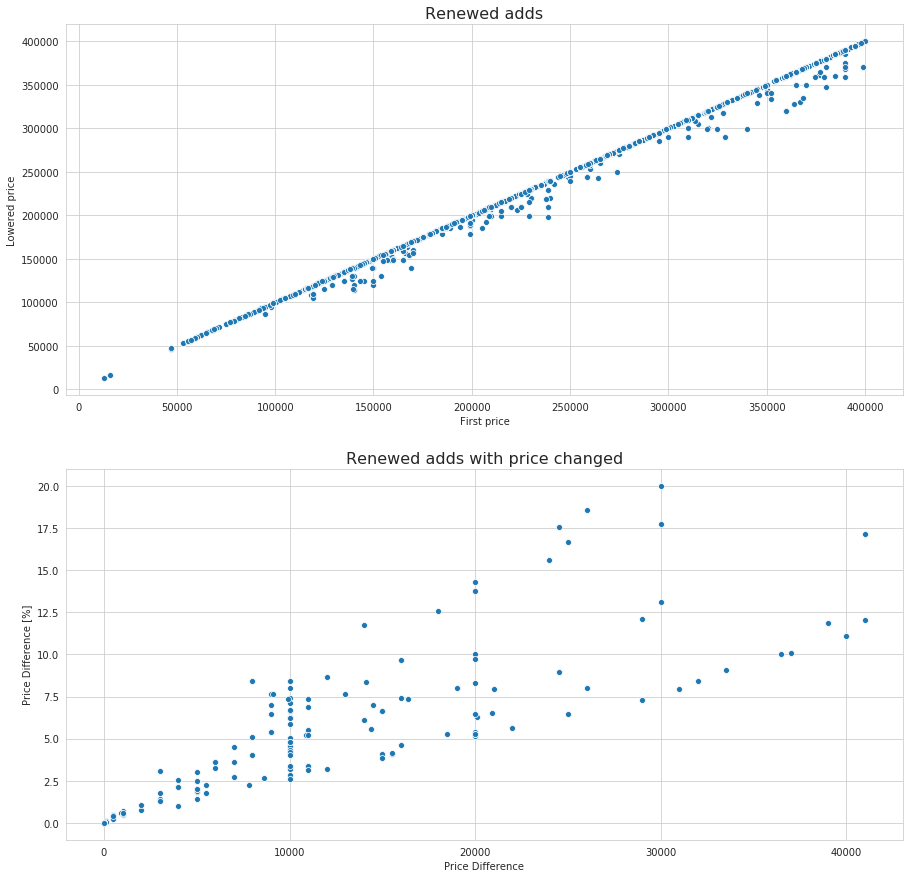

In [8]:
fig_size = (15, 15)
fig, ax = plt.subplots(2, figsize=fig_size)
df.propertyCode = df.propertyCode.astype(str)
sns.scatterplot(y='dupPriceMin', x='dupPriceMax', data=df, ax=ax[0])
ax[0].set_title('Renewed adds', fontsize=16)
ax[0].set_xlabel('First price')
ax[0].set_ylabel('Lowered price')

sns.scatterplot(x='dupPriceDifference', y='dupPriceDifference%', data=df, ax=ax[1])
ax[1].set_title('Renewed adds with price changed', fontsize=16)
ax[1].set_xlabel('Price Difference')
ax[1].set_ylabel('Price Difference [%]')

changed_price = ((df['dupPriceMin'] - df['dupPriceMax']) == 0).sum()
percent_changed_price = 100 * changed_price / df.shape[0]
print('There are {} renewes adds without change in price ({:.2f}%)'.format(
    changed_price, percent_changed_price))

## Impute missing district and neighborhood
Impute missing district and neighborhood based on kNN and geolocation (latitude, longitude)

In [9]:
print('\n\n There are '+ repr(df.district.isnull().sum()) +' Null Elements in district to be imputed.')

index_missing = df.index[df.district.isnull()]

X = df.dropna(subset=['district']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['district']).loc[:,'district']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## Evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'district'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 60 Null Elements in district to be imputed.


In [10]:
print('\n\n There are '+ repr(df.neighborhood.isnull().sum()) +' Null Elements in neighborhood to be imputed.')

index_missing = df.index[df.neighborhood.isnull()]

X = df.dropna(subset=['neighborhood']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['neighborhood']).loc[:,'neighborhood']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'neighborhood'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 66 Null Elements in neighborhood to be imputed.


## Analyze property types

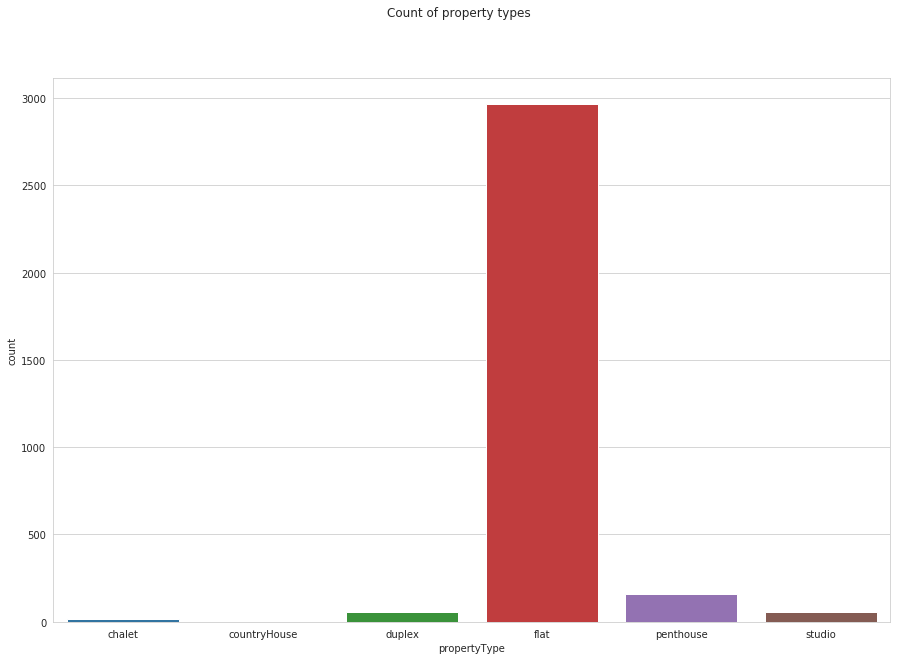

In [11]:
fig_size = (15,10)
fig, ax = plt.subplots(1,figsize=fig_size)
sns.countplot(x='propertyType', data=df, ax=ax);
fig.suptitle('Count of property types');

### Check distribution of Price, Size, and Price by Area

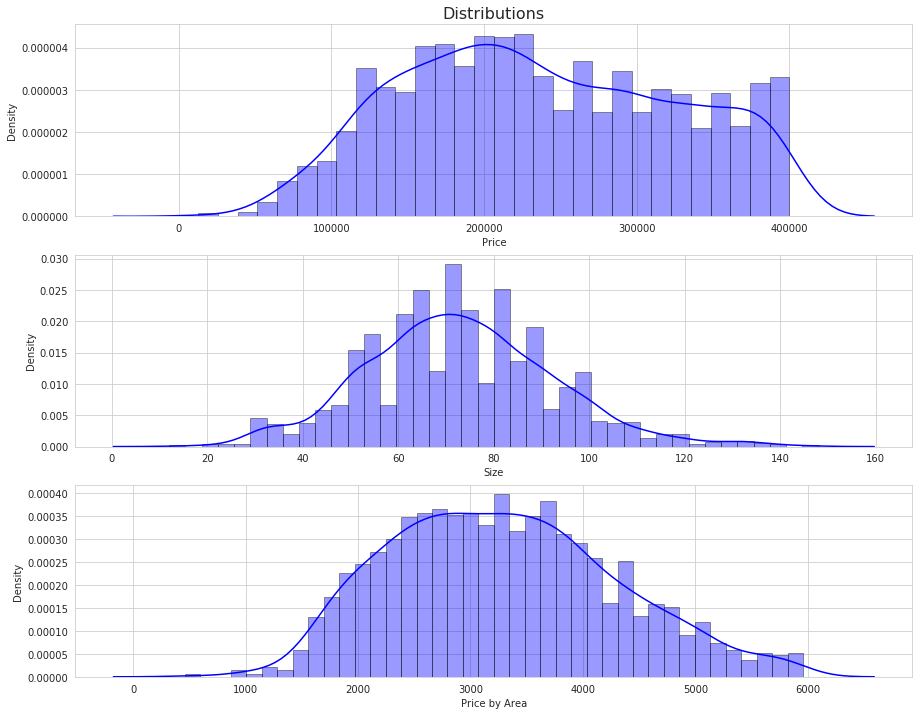

In [12]:
# Prices over 400k are exluded when requesting info from Idealista
fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

sns.distplot(df['price'], hist=True, kde=True, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[0])
ax[0].set_title('Distributions', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');


sns.distplot(df['size'], hist=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[1])
ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');


sns.distplot(df['priceByArea'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[2])
ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');


In [ ]:
# Check for each type of property

fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

for typeOfProperty in df.propertyType.unique():
    dfDist = df.loc[df['propertyType']==typeOfProperty, ['price', 'size', 'priceByArea']]
    
    sns.distplot(dfDist['price'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[0])
    
    sns.distplot(dfDist['size'], hist=False, kde=True,
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[1])
    
    sns.distplot(dfDist['priceByArea'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[2])
    
# Add labels
ax[0].set_title('Distributions per property type', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');

ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');

ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');
    
    

### Scatter plot of Price by Area vs. Size for each property type

In [ ]:
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
sns.scatterplot(y='priceByArea', x='size', hue='propertyType', data=df, ax=ax)
fig.suptitle('Price by area vs. size', fontsize=16);


### Number of rooms

In [ ]:
sns.set_style("whitegrid")
fig_size = (15,12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='rooms', orient = 0, data = df, ax = ax[0])
ax[0].set_title('Number of rooms per apartment', fontsize=16);
ax[0].set_ylabel('Count');

sns.countplot(x = 'district', hue = 'rooms', orient = 0, data = df, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
ax[1].set_title('Number of rooms per apartment per deistrict');
ax[1].set_ylabel('Count');


## Analyze the relationship of floor and price

### Clean floors
Clean floors and create new numerical column 'floorSort' with floor values

In [ ]:
df['floor'] = df['floor'].astype('string')
df['floorSort'] = df['floor']
df['floorSort'].replace('en', str(0), inplace= True) # entreplanta = 0
df['floorSort'].replace('bj', str(-1), inplace= True) # bajo = -1
df['floorSort'].replace('ss', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('st', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('nan', str(-2), inplace= True) # nan = -2
df['floorSort'].replace('Unknown', str(-1), inplace= True) # Set unknown to -2

df.floorSort = df.floorSort.apply(pd.to_numeric)

# 'st' and 'ss' are bothsemisotano
df['floor'].replace('st', 'ss', inplace= True) 

# Show property type 'Penthouse' as floor
df.loc[df['propertyType'] == 'penthouse', 'floor'] =  'Penthouse'# Set unknown to -2
df.loc[df['propertyType'] == 'penthouse', 'floorSort'] =  df.floorSort.max() + 1# Set unknown to -2

# Create new categorical variable with floors
df['floorCategorical'] = df['floor']
df.loc[df['floorSort']==-2, ['floorCategorical']] = None
df.loc[(df['floorSort']>=1)&(df['floorSort']<=3), ['floorCategorical']] = 'Low'
df.loc[(df['floorSort']>=4)&(df['floorSort']<=6), ['floorCategorical']] = 'Mid'
df.loc[(df['floorSort']>=7)&(df['floor']!='Penthouse'), ['floorCategorical']] = 'High'
df['floorCategorical'] = df['floorCategorical'].astype('category')


### Counts and price distribution per floor

In [ ]:
# Do not plot NaNs
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor (Violinplots are scaled by count)', fontsize=16)
sns.countplot(x='floor', data=df.loc[df['floorSort'] != -
                                     2].sort_values(by=['floorSort']), orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floor', y='size',
            data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floor', y='priceByArea', scale='count',
               data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')


# Plot 'floorCategorical'
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor', fontsize=16)
sns.countplot(x='floorCategorical', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floorCategorical', y='size', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floorCategorical', y='priceByArea', scale='width', data=df,
               order=['ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')

### Analyze number of penthouses per district

In [ ]:
def get_penthouse(x):
    return x.loc[x == 'penthouse'].count()


def get_all_properties(x):
    return x.count()


fig, ax = plt.subplots(1, figsize=(15, 10))


aux = df[['district', 'propertyType']].groupby(['district']).agg(
    [get_penthouse, get_all_properties])
aux.columns = ['Penthouses', 'All properties']
aux.sort_values(by='Penthouses').plot.barh(stacked=True, ax=ax)
ax.set_title(
    'Number of penthouses per district with respect to the total number of properties', 
    fontsize=16);

## Location

### Plot properties to the map
Plot properties and penthouses with respect to price by area and size.

In [ ]:
import geopandas as gpd
import descartes
import contextily as ctx


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15,15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='priceByArea', cmap='hot',  legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='priceByArea', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area - Only penthouses", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='size', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Size", fontsize=16);

### Analyze prices per district

In [ ]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='district', data=df,
              order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index, orient='v', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Total number of properties per district', fontsize=16);

sns.boxplot(y='priceByArea', x='district', data=df, ax=ax[1],
            order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right')
ax[1].set_title(
    'Price per district', fontsize=16);

### Change in price over time
Check the fluctuations per week

In [ ]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='Week', data=df, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Number of properties per week', fontsize=16);

sns.violinplot(x='Week', y='priceByArea', data=df, ax=ax[1])
ax[1].set_title(
    'Prices per week', fontsize=16);

# Analysis of apartment status

In [ ]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='status', data=df, ax=ax[0]);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.violinplot(y='priceByArea', x= 'status', data=df, ax=ax[1])
fig.suptitle('Analysis of status of the apartments', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='status', data=df, ax=ax[0],
             order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.boxplot(x='district', y='priceByArea', hue='status',data=df,ax=ax[1],
           order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of status of the apartments by district', fontsize=16);

## Analysis of elevator
Check if the elevator has an effect on the price

In [ ]:
# Compare price by area depending on the floor and the lift
fig_size = (12, 10)
fig, ax = plt.subplots(1, figsize=fig_size)
aux=df
aux['highFloor']=False
aux.loc[aux['floorSort']>2, 'highFloor'] = True
sns.violinplot(x='hasLift', y='priceByArea', hue='highFloor', scale='count', data=aux,ax=ax);
ax.set_title('Price by area vs lift vs floor (Violin plots are scaled with respect to count)', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='hasLift', data=df, ax=ax[0],
             order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='hasLift', data=df,ax=ax[1],
           order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Price by area vs elevator', fontsize=16);

## Exterior/interior
Check  the effect of interior/exterior property on the price

In [ ]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='exterior', data=df, ax=ax[0],
             order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='exterior',data=df,ax=ax[1],
           order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of exterior/interior apartments', fontsize=16);

# Price Prediction
Using regression a price for each property is predicted. The properties with a significantly lower price than the predicted value are identified as a good investment oportunity.

### Organize and clean the data

In [ ]:
# Print the names of the columns
print('Available features are:')
for i in df.columns:
    print(i, end=', ')

df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]

In [ ]:
def clean_modelling_data(df, dropNaN=True):
    data = df
    
    # drop NaNs
    numberOfNans = data.isnull().sum().sum()/data.shape[0]
    #assert numberOfNans<0.05, "Oh no! The number of NaNs is "+str(numberOfNans)+"%"
    print("The number of NaNs is "+str(numberOfNans)+"%")
    if dropNaN==True:
        print ("NaN's dropped.")
        data = data.dropna().reset_index(drop=True)
   # data['hasLift'] = data['hasLift'].astype('bool')

    # get 0/1 for bool varibales
    data['exterior'] = data['exterior'].astype(int)
    #data['hasLift'] = data['hasLift'].astype(int)

    # get dummies for categorical variables
    data = pd.get_dummies(data)
    return data

df_model = clean_modelling_data(df_model)

### Linear Regression
Simple linear regression model and the performance

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

reg = LinearRegression()

labels = df_model['priceByArea']
train1 = df_model.drop(['priceByArea'],axis=1)
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.25,random_state =2)

reg.fit(x_train,y_train)
reg.score(x_test,y_test)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))
fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);

#plt.scatter(y_test, reg.predict(x_test),  color='black');

#### Improve the linear regression using ensemble learner
Improve the linear regression using Gradient Boosting Regressor

In [ ]:
params = {'n_estimators': 1000,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig,ax= plt.subplots(1,figsize=(15, 10))

plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
        label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test set deviance')
        
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance')

fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);


In [ ]:
# Analyze error on Penthouses
R2_test_penthouse = reg.score(
    x_test.loc[x_test['propertyType_penthouse'] == 1], y_test.loc[x_test['propertyType_penthouse'] == 1])
print("The R square (R2) on test set: {:.4f}".format(R2_test_penthouse))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(x=y_test.loc[x_test['propertyType_penthouse'] == 1], y=reg.predict(
    x_test.loc[x_test['propertyType_penthouse'] == 1]))
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction - Penthouses', fontsize=16);

#### Perform Permutation Feature Importance analysis

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(train1.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(train1.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()

### Identify the best offers in terms of Price by Area

#### Train the model on all samples

In [ ]:
# Recreate feature set
#df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
#              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]
#df_model_train = clean_modelling_data(df_model, dropNaN=True)
# Drop unnecessary features
#df_model_train = df_model_train.drop(['propertyType_studio', 'propertyType_duplex', 'propertyType_countryHouse', 'propertyType_chalet',
#                          'status_newdevelopment', 'status_good', 'exterior',
#                         'floorCategorical_High', 'floorCategorical_Mid', 'floorCategorical_en', 'floorCategorical_ss',
#                          'floorCategorical_Penthouse'
#                         ], axis=1)


# Don't use status ad has lift becasue these features contain a lot of nans
df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'Week', 'floorCategorical']]
df_model.loc[df_model['floorCategorical'].isnull()]='Low'
1/0
df_model = clean_modelling_data(df_model, dropNaN=True)
# Drop unnecessary features
df_model = df_model.drop(['propertyType_studio', 'propertyType_duplex', 'propertyType_countryHouse', 'propertyType_chalet',
                        'exterior', 'floorCategorical_High', 'floorCategorical_Mid', 'floorCategorical_en', 'floorCategorical_ss',
                          'floorCategorical_Penthouse'
                         ], axis=1)

print('Using features:')
for i in df_model.columns:
    print(i, end=', ')
df_model.loc[df_model]


# Print the names of the columns
print('Using features:')
for i in df_model.columns:
    print(i, end=', ')

params = {'n_estimators': 400,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(df_model.drop(['priceByArea'], axis=1), df_model['priceByArea'])

mse_train = mean_squared_error(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
R2_train = reg.score(df_model.drop(
    ['priceByArea'], axis=1), df_model['priceByArea'])
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The R square (R2) on train set: {:.4f}".format(R2_train))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
ax.set_ylabel('True price by area');
ax.set_xlabel('Predicted price by area');
ax.set_title('Price by area prediction', fontsize=16);

#### Create new columns in df with predicted price, price difference, and savings

In [ ]:
df_model['predictedPrice'] = reg.predict(df_model.drop(['priceByArea'],axis=1))
# Price difference = PredictedPrice- priceByArea ==> the higher numbers are better investment
df_model['priceDifference'] = df_model['predictedPrice']-df_model['priceByArea']

df=df.join(df_model[['predictedPrice', 'priceDifference']])
df['savings'] = df['size']*df['priceDifference']

Show only the properties cheaper more than 'threshold' than predicted price (e.g. 10 000 euros).

In [ ]:
# show only the properties cheaper by threashold from predicted price 
saving_threashold = 10000
df_investment=df.loc[df['savings'] > saving_threashold]

df_investment.sort_values(by='savings',ascending=False).head(50)

#### Plot the identified properties on the map

In [ ]:
gdf = gpd.GeoDataFrame(
    df_investment, geometry=gpd.points_from_xy(df_investment.longitude, df_investment.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Savings - all property types", fontsize=16)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Savings - Penthouses", fontsize=16)

In [ ]:
fig,ax= plt.subplots(2,figsize=(15, 10))
sns.scatterplot(x='size', y='savings', hue= 'propertyType', data=df_investment,ax=ax[0]);
#sns.scatterplot(x='size', y='priceByArea', hue= 'savings', data=df,ax=ax[1]);
sns.scatterplot(x='size', y='priceByArea', size= 'savings', hue='propertyType', data=df_investment,ax=ax[1]);

#### Get the identifier of the selected property

In [ ]:
# E.g.:
df_investment.loc[(df_investment['size'] > 70) & (df_investment['size'] < 100) & (
    df_investment['propertyType'] == 'penthouse')].sort_values(by='savings', ascending=False)